# Intent Classification using Deep Learning

## 1. Loading Data

In [1]:
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.lancaster import LancasterStemmer
import nltk
import re
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, GRU, LSTM, Bidirectional, Embedding, Dropout
from keras.callbacks import ModelCheckpoint

Dataset link: https://raw.githubusercontent.com/PolyAI-LDN/task-specific-datasets/master/banking_data/train.csv

In [2]:
Intent = "category"
Sentence = "text"

In [3]:
def load_dataset(filename, Sentence, Intent):
  df = pd.read_csv(filename, names = [Sentence, Intent])
  intent = df[Intent]
  unique_intent = list(set(intent))
  sentences = list(df[Sentence])
  
  return (df, intent, unique_intent, sentences)

In [4]:
df, intent, unique_intent, sentences = load_dataset("Dataset.csv", "text", "category")

In [6]:
print(df.head(10))

                                                text      category
0                                               text      category
1                     I am still waiting on my card?  card_arrival
2  What can I do if my card still hasn't arrived ...  card_arrival
3  I have been waiting over a week. Is the card s...  card_arrival
4  Can I track my card while it is in the process...  card_arrival
5  How do I know if I will get my card, or if it ...  card_arrival
6                  When did you send me my new card?  card_arrival
7       Do you have info about the card on delivery?  card_arrival
8  What do I do if I still have not received my n...  card_arrival
9       Does the package with my card have tracking?  card_arrival


<AxesSubplot:xlabel='category', ylabel='count'>

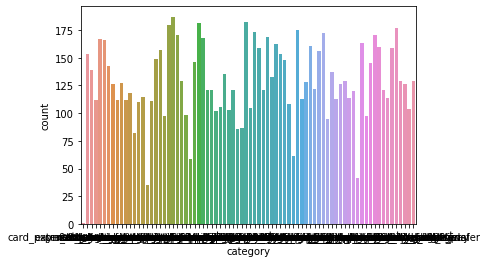

In [7]:
import seaborn as sns
import tkinter
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
%matplotlib inline
sns.countplot(x=Intent, data=df)

In [8]:
print(sentences[:5])

['text', 'I am still waiting on my card?', "What can I do if my card still hasn't arrived after 2 weeks?", 'I have been waiting over a week. Is the card still coming?', 'Can I track my card while it is in the process of delivery?']


In [9]:
nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/shiningflash/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/shiningflash/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## 2. Data Cleaning

In [10]:
#define stemmer
stemmer = LancasterStemmer()

In [11]:
def cleaning(sentences):
  words = []
  for s in sentences:
    clean = re.sub(r'[^ a-z A-Z 0-9]', " ", s)
    w = word_tokenize(clean)
    words.append([i.lower() for i in w])
    
  return words 

In [12]:
cleaned_words = cleaning(sentences)
print(len(cleaned_words))
print(cleaned_words[:2])  

10004
[['text'], ['i', 'am', 'still', 'waiting', 'on', 'my', 'card']]


## 3. Texts Tokenization

In [13]:
def create_tokenizer(words, filters = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~'):
  token = Tokenizer(filters = filters)
  token.fit_on_texts(words)
  return token

In [14]:
def max_length(words):
  return(len(max(words, key = len)))

In [15]:
word_tokenizer = create_tokenizer(cleaned_words)
vocab_size = len(word_tokenizer.word_index) + 1
max_length = max_length(cleaned_words)

print("Vocab Size = %d and Maximum length = %d" % (vocab_size, max_length))

Vocab Size = 2343 and Maximum length = 84


In [16]:
def encoding_doc(token, words):
  return(token.texts_to_sequences(words))

In [17]:
encoded_doc = encoding_doc(word_tokenizer, cleaned_words)

In [18]:
def padding_doc(encoded_doc, max_length):
  return(pad_sequences(encoded_doc, maxlen = max_length, padding = "post"))

In [19]:
padded_doc = padding_doc(encoded_doc, max_length)

In [20]:
print("Shape of padded docs = ",padded_doc.shape)

Shape of padded docs =  (10004, 84)


In [21]:
#tokenizer with filter changed
output_tokenizer = create_tokenizer(unique_intent, filters = '!"#$%&()*+,-/:;<=>?@[\]^`{|}~')

In [22]:
output_tokenizer.word_index

{'verify_source_of_funds': 1,
 'topping_up_by_card': 2,
 'balance_not_updated_after_cheque_or_cash_deposit': 3,
 'visa_or_mastercard': 4,
 'request_refund': 5,
 'extra_charge_on_statement': 6,
 'wrong_amount_of_cash_received': 7,
 'atm_support': 8,
 'card_payment_fee_charged': 9,
 'pending_card_payment': 10,
 'transfer_fee_charged': 11,
 'getting_spare_card': 12,
 'wrong_exchange_rate_for_cash_withdrawal': 13,
 'top_up_by_cash_or_cheque': 14,
 'category': 15,
 'transfer_not_received_by_recipient': 16,
 'top_up_by_bank_transfer_charge': 17,
 'unable_to_verify_identity': 18,
 'refund_not_showing_up': 19,
 'pending_transfer': 20,
 'pin_blocked': 21,
 'top_up_by_card_charge': 22,
 'country_support': 23,
 'getting_virtual_card': 24,
 'pending_cash_withdrawal': 25,
 'card_payment_wrong_exchange_rate': 26,
 'declined_cash_withdrawal': 27,
 'fiat_currency_support': 28,
 'lost_or_stolen_phone': 29,
 'transfer_into_account': 30,
 'passcode_forgotten': 31,
 'terminate_account': 32,
 'verify_top_u

In [23]:
encoded_output = encoding_doc(output_tokenizer, intent)

In [24]:
encoded_output = np.array(encoded_output).reshape(len(encoded_output), 1)

In [25]:
encoded_output.shape

(10004, 1)

In [26]:
def one_hot(encode):
  o = OneHotEncoder(sparse = False)
  return(o.fit_transform(encode))

In [27]:
output_one_hot = one_hot(encoded_output)

In [28]:
output_one_hot.shape

(10004, 78)

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
train_X, val_X, train_Y, val_Y = train_test_split(padded_doc, output_one_hot, shuffle = True, test_size = 0.2)

In [31]:
print("Shape of train_X = %s and train_Y = %s" % (train_X.shape, train_Y.shape))
print("Shape of val_X = %s and val_Y = %s" % (val_X.shape, val_Y.shape))

Shape of train_X = (8003, 84) and train_Y = (8003, 78)
Shape of val_X = (2001, 84) and val_Y = (2001, 78)


## 4. Bidirectional GRU 

In [32]:
from livelossplot.tf_keras import PlotLossesCallback
from livelossplot import PlotLossesKeras

In [33]:
def create_model(vocab_size, max_length):
  model = Sequential()
  model.add(Embedding(vocab_size, 128, input_length = max_length, trainable = False))
  model.add(Bidirectional(GRU(128)))
  model.add(Dense(32, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(78, activation = "softmax"))
  
  return model

In [34]:
model = create_model(vocab_size, max_length)

model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 84, 128)           299904    
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               198144    
_________________________________________________________________
dense (Dense)                (None, 32)                8224      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 78)                2574      
Total params: 508,846
Trainable params: 208,942
Non-trainable params: 299,904
_________________________________________________________________


In [35]:
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')

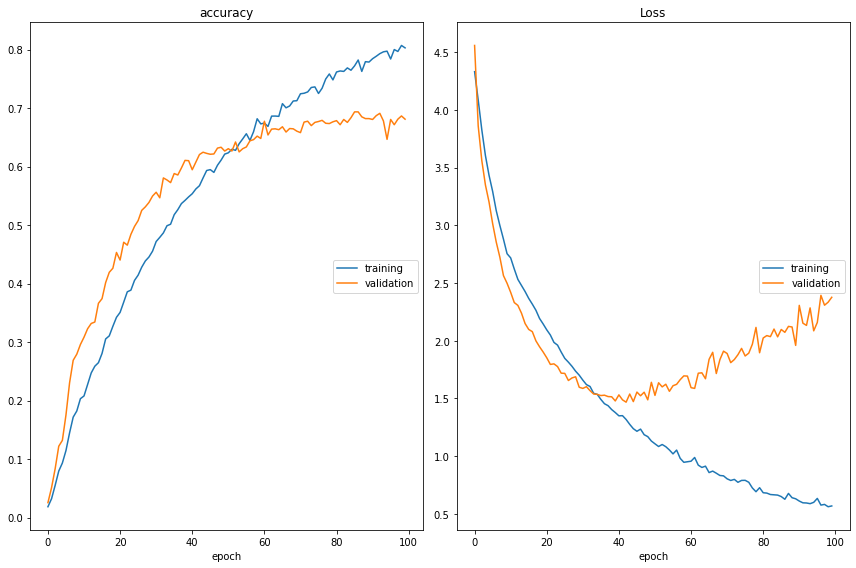

accuracy
	training         	 (min:    0.018, max:    0.807, cur:    0.803)
	validation       	 (min:    0.025, max:    0.694, cur:    0.681)
Loss
	training         	 (min:    0.562, max:    4.331, cur:    0.568)
	validation       	 (min:    1.468, max:    4.558, cur:    2.376)

Epoch 00100: val_loss did not improve from 1.46752
251/251 [==============================] - 27s 107ms/step - loss: 0.5683 - accuracy: 0.8031 - val_loss: 2.3763 - val_accuracy: 0.6812


In [36]:
hist = model.fit(train_X, train_Y,
                 epochs = 100,
                 batch_size = 32,
                 validation_data = (val_X, val_Y),
                 callbacks = [PlotLossesKeras(), checkpoint])

## 5. Bidirectional LSTM 

In [37]:
def create_model(vocab_size, max_length):
  model = Sequential()
  model.add(Embedding(vocab_size, 128, input_length = max_length, trainable = False))
  model.add(Bidirectional(LSTM(128)))
  model.add(Dense(32, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(78, activation = "softmax"))
  
  return model

model_lstm = create_model(vocab_size, max_length)

model_lstm.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 84, 128)           299904    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_2 (Dense)              (None, 32)                8224      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 78)                2574      
Total params: 573,870
Trainable params: 273,966
Non-trainable params: 299,904
_________________________________________________________________


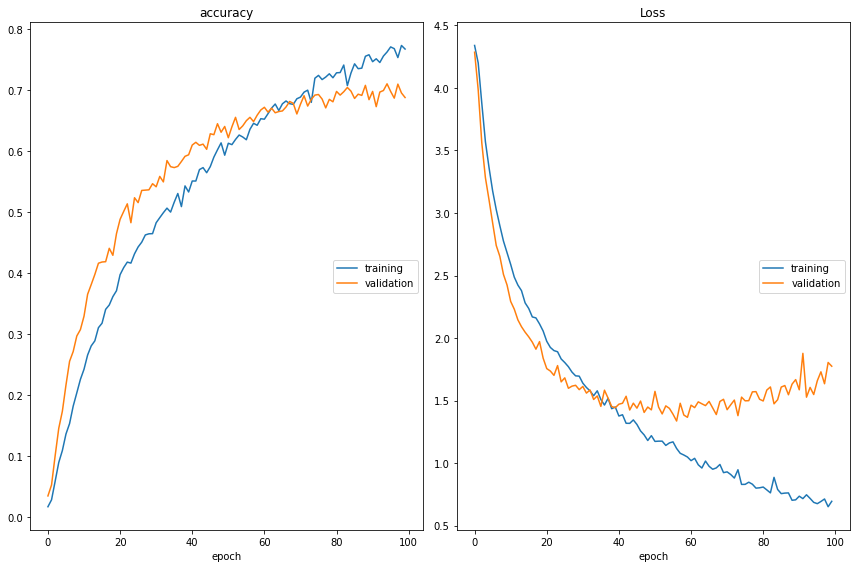

accuracy
	training         	 (min:    0.017, max:    0.774, cur:    0.768)
	validation       	 (min:    0.034, max:    0.711, cur:    0.688)
Loss
	training         	 (min:    0.651, max:    4.339, cur:    0.695)
	validation       	 (min:    1.337, max:    4.285, cur:    1.775)

Epoch 00100: val_loss did not improve from 1.33676
251/251 [==============================] - 27s 108ms/step - loss: 0.6949 - accuracy: 0.7677 - val_loss: 1.7749 - val_accuracy: 0.6882


In [38]:
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')

hist = model_lstm.fit(train_X, train_Y,
                 epochs = 100,
                 batch_size = 32,
                 validation_data = (val_X, val_Y),
                 callbacks = [PlotLossesKeras(), checkpoint])

### Prediction

In [39]:
model_lstm = load_model("model.h5")

In [40]:
def predictions(text):
  clean = re.sub(r'[^ a-z A-Z 0-9]', " ", text)
  test_word = word_tokenize(clean)
  test_word = [w.lower() for w in test_word]
  test_ls = word_tokenizer.texts_to_sequences(test_word)
  
  #Check for unknown words
  if [] in test_ls:
    test_ls = list(filter(None, test_ls))
    
  test_ls = np.array(test_ls).reshape(1, len(test_ls))
  x = padding_doc(test_ls, max_length)

  pred = model_lstm.predict(x)
  return pred

In [41]:
def get_final_output(pred, classes):
  predictions = pred[0]
  classes = np.array(classes)
  ids = np.argsort(-predictions)
  classes = classes[ids]
  predictions = -np.sort(-predictions)
 
  for i in range(pred.shape[1]):
    print("%s has confidence = %s" % (classes[i], (predictions[i])))
  
  return classes[0]

In [42]:
text = "I am still waiting on my card?"
pred = predictions(text)
result = get_final_output(pred, unique_intent)
print('\nans: {}\n'.format(result))

card_arrival has confidence = 0.5400851
lost_or_stolen_card has confidence = 0.13254714
card_not_working has confidence = 0.099424854
contactless_not_working has confidence = 0.05694259
compromised_card has confidence = 0.02806151
card_about_to_expire has confidence = 0.024988813
card_delivery_estimate has confidence = 0.024908025
declined_card_payment has confidence = 0.023217054
card_linking has confidence = 0.019666543
activate_my_card has confidence = 0.019631721
card_swallowed has confidence = 0.015140002
reverted_card_payment? has confidence = 0.011102826
atm_support has confidence = 0.0015607645
declined_cash_withdrawal has confidence = 0.0007894527
lost_or_stolen_phone has confidence = 0.00065130007
card_payment_not_recognised has confidence = 0.00042219783
cash_withdrawal_not_recognised has confidence = 0.0002289453
card_acceptance has confidence = 0.0001782307
declined_transfer has confidence = 0.00015152607
pin_blocked has confidence = 9.299157e-05
passcode_forgotten has con

In [45]:
def get_only_final_output(pred, classes):
  predictions = pred[0]
  classes = np.array(classes)
  ids = np.argsort(-predictions)
  classes = classes[ids]
  predictions = -np.sort(-predictions)
  
  return classes[0]

In [48]:
def get_intent(text):
  pred = predictions(text)
  result = get_only_final_output(pred, unique_intent)
  print('ans: {}'.format(result))

In [49]:
get_intent("I am still waiting on my card?")

ans: card_arrival


In [50]:
get_intent("What are you exchange rates?")

ans: exchange_rate


In [51]:
get_intent("Which countries are represented?")

ans: country_support
